In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import pickle 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics.classification import log_loss
from sklearn.metrics import confusion_matrix


In [2]:
# function to load the pickle data
def loadPickleData(filename):
    pickle_off = open(filename,"rb")
    final = pickle.load(pickle_off)
    return final


In [3]:
# load the y values because they are common across all feature engineering
y_train = loadPickleData('y_train.pickle')
y_test = loadPickleData('y_test.pickle')
y_cv = loadPickleData('y_cv.pickle')

In [6]:
# Encode labels

encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_train = np.ravel(encoded_column_vector)

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_test = np.ravel(encoded_column_vector)

encoded_column = label_binarize(y_cv, classes=['negative','positive']) # ham will be 0 and spam will be 1
y_cv = np.ravel(encoded_column)

In [7]:
len(y_train)

69920

In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [9]:
def calculateMetricC(X,y,alpha,train,y_train):
    fpr_array = []
    sparsity_array = []
    for i in alpha:
            print("for alpha =", i)
            clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l1', loss='log', random_state=42)
            clf.fit(train, y_train)
            sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
            sig_clf.fit(train, y_train)
            pred = sig_clf.predict(X)
            tn, fp, fn, tp = confusion_matrix(y, pred,labels=[0,1]).ravel()
            if fp == 0 and tp ==0:
                fpr = np.inf
            else:
                fpr = fp/(fp+tn)  
            fpr_array.append(fpr)
            sparsity = findSparsity(clf)
            sparsity_array.append(sparsity)
            print("Fpr :",fpr)
            print("Sparsity :",sparsity)    
    return fpr_array,sparsity_array

In [10]:
def drawplots(alpha,cv_log_error_array,sparsity_array,train_log_error_array):
    fig, ax = plt.subplots(2,1,figsize=(15,15))
    a = np.arange(len(alpha))
    ax[0].plot(a, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],cv_log_error_array[i]))
    
    ax[0].plot(a, train_log_error_array,c='r')
    for i, txt in enumerate(np.round(train_log_error_array,3)):
        ax[0].annotate((a[i],str(txt)), (a[i],train_log_error_array[i]),(a[i]+0.005,train_log_error_array[i]+0.015))
        
    ax[0].set_xticks(a)
    ax[0].set_xticklabels(alpha)
    plt.grid()
    ax[0].set_title("Cross Validation Error for each alpha")
    ax[0].set_xlabel("Alpha i's")
    ax[0].set_ylabel("Error measure")
#    ax[0].set_legend(loc= 4)


    ax[1].plot(a, sparsity_array,c='b')
    for i, txt in enumerate(sparsity_array):
        ax[1].annotate((alpha[i],str(txt)), (a[i],sparsity_array[i]))
    ax[1].set_xticks(a)
    ax[1].set_xticklabels(alpha)
    ax[1].set_title("Non zero values for each alpha")
    ax[1].set_xlabel("Alpha i's")
    plt.show()    

In [11]:
# performs hyperparameter tuning for logistic regression
def performHyperParameterTuningC(train,cv,test):
    alpha = [10 ** x for x in range(-14, 3)]
    fpr_array = []
    sparsity_array = []
    fpr_error_array,sparsity_array = calculateMetricC(cv,y_cv,alpha,train,y_train)
    fpr_error_array_train,train_sparsity_array = calculateMetricC(train,y_train,alpha,train,y_train)

    drawplots(alpha,fpr_error_array,sparsity_array,fpr_error_array_train)
    best_alpha = np.argmin(fpr_error_array)
    clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train, y_train)

    predict_y = sig_clf.predict(train)
    tn, fp, fn, tp = confusion_matrix(y_train, predict_y,labels=[0,1]).ravel()
    plot_confusion_matrix(y_train,predict_y)
    print('For values of best alpha = ', alpha[best_alpha], "The train fpr is:",fp/(fp+tn))
    predict_y = sig_clf.predict(cv)
    tn, fp, fn, tp = confusion_matrix(y_cv, predict_y,labels=[0,1]).ravel()
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation fpr is:",fp/(fp+tn))
    predict_y = sig_clf.predict(test)
    tn, fp, fn, tp = confusion_matrix(y_test, predict_y,labels=[0,1]).ravel()
    plot_confusion_matrix(y_test,predict_y)
    print('For values of best alpha = ', alpha[best_alpha], "The test fpr is:",fp/(fp+tn))
    return clf,alpha[best_alpha]

In [12]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

#     # for calculating log_loss we willl provide the array of probabilities belongs to each class
#     print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
#     # calculating the number of data points that are misclassified
#     print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [13]:
def plot(data):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(data)

In [14]:
def findPercentageDifference(w,w_new):
    z =np.subtract(w,w_new)
    q = np.linalg.norm(w)
    a = abs(np.divide(z,q))*100
    return a

In [15]:
def doPertubation(train):
    e = np.random.normal(0,0.1)
    #train_1 = np.add(train,e)
    train_1 = train.data + e
    train.data = train_1
    return train

In [16]:
# def findSparsity(clf):
#     coef_list =  clf.coef_.ravel()
#     sparsity_LR = np.mean(coef_list == 0) * 100
#     print("Sparsity is :" ,sparsity_LR)

In [17]:
def findSparsity(clf):
    coef_list =  clf.coef_.ravel()
    non_sparse = coef_list[coef_list !=0]
    return non_sparse.size

In [18]:
def getImportantFeatures(indices,feature_names):
    words =[]
    for x in indices:
        words.append(feature_names[x])
    return words

# BOW

In [19]:
train = loadPickleData("bow_train.pickle")
test = loadPickleData('bow_test.pickle')
cv = loadPickleData('bow_cv.pickle')

In [20]:
count_vect = loadPickleData('count_vect.pickle')
feature_names = count_vect.get_feature_names()

In [21]:
cv.shape

(17480, 3185692)

for alpha = 1e-14
Fpr : 1.0
Sparsity : 1225518
for alpha = 1e-13
Fpr : 0.4283108354615104
Sparsity : 1227950
for alpha = 1e-12
Fpr : 0.42977015687705217
Sparsity : 1231069
for alpha = 1e-11
Fpr : 0.4294053265231667
Sparsity : 1232969
for alpha = 1e-10
Fpr : 0.41700109449106165
Sparsity : 1228125
for alpha = 1e-09
Fpr : 0.4275811747537395
Sparsity : 1208696
for alpha = 1e-08
Fpr : 0.4239328712148851
Sparsity : 1198316
for alpha = 1e-07
Fpr : 0.4097044874133528
Sparsity : 1133802
for alpha = 1e-06
Fpr : 0.41444728201386355
Sparsity : 1018442
for alpha = 1e-05
Fpr : 0.4334184604159066
Sparsity : 315266
for alpha = 0.0001
Fpr : 0.5063845311929952
Sparsity : 22695
for alpha = 0.001
Fpr : 0.6621670923020795
Sparsity : 1975
for alpha = 0.01
Fpr : 0.939073330901131
Sparsity : 268
for alpha = 0.1
Fpr : 1.0
Sparsity : 2
for alpha = 1
Fpr : 1.0
Sparsity : 0
for alpha = 10
Fpr : 1.0
Sparsity : 0
for alpha = 100
Fpr : 1.0
Sparsity : 0
for alpha = 1e-14
Fpr : 1.0
Sparsity : 1225518
for alpha = 1e-13

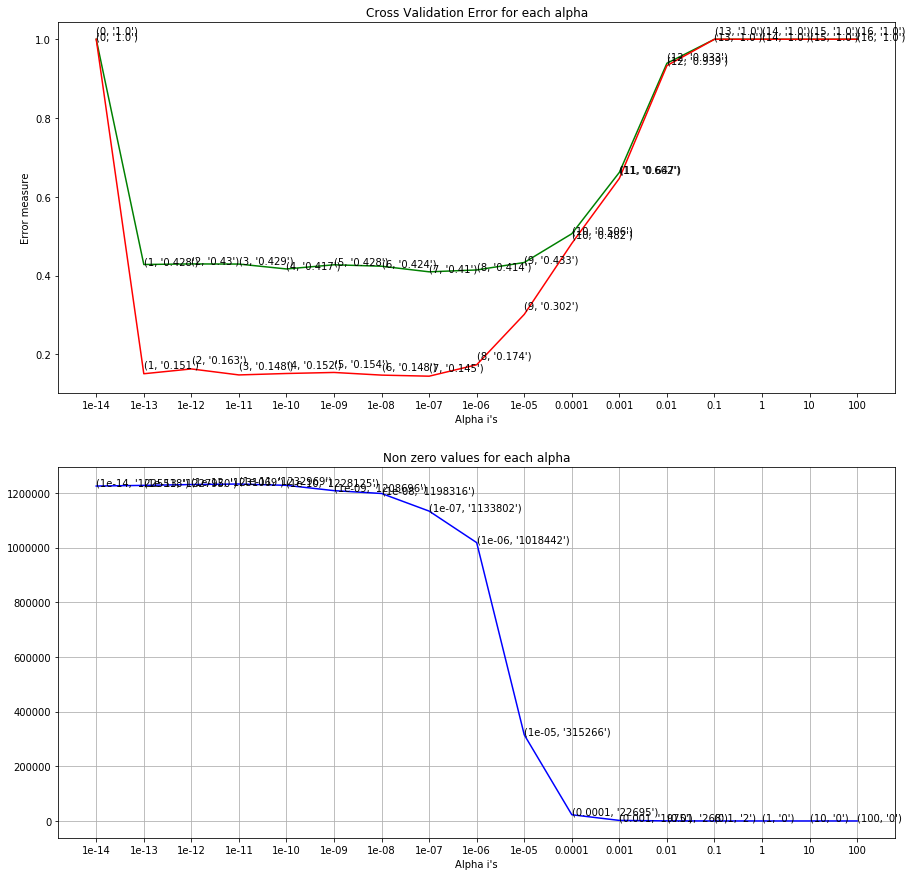

-------------------- Confusion matrix --------------------


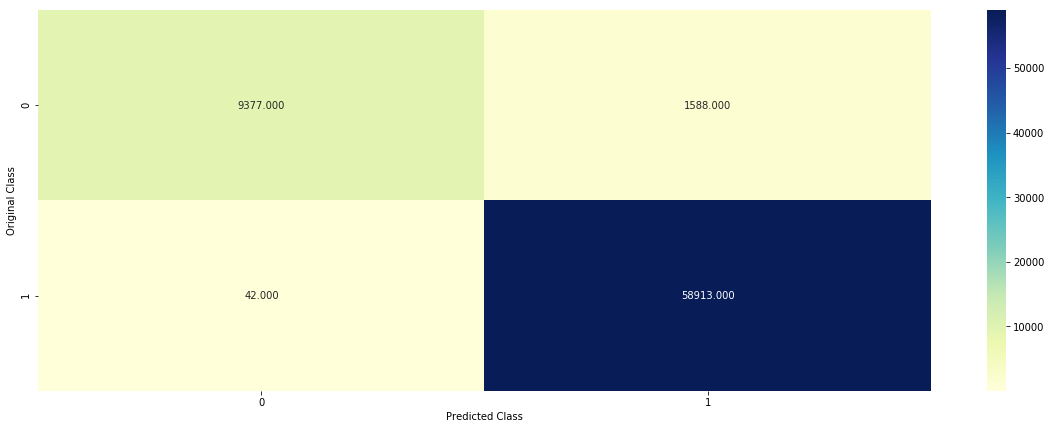

For values of best alpha =  1e-07 The train fpr is: 0.14482444140446876
For values of best alpha =  1e-07 The cross validation fpr is: 0.4097044874133528
-------------------- Confusion matrix --------------------


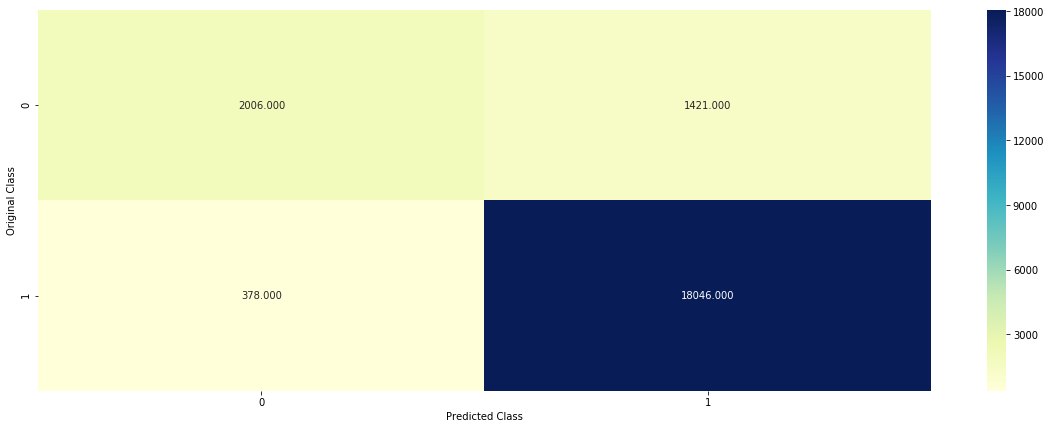

For values of best alpha =  1e-07 The test fpr is: 0.41464838050773273


In [22]:
clf,alph = performHyperParameterTuningC(train,cv,test)

Train
-------------------- Confusion matrix --------------------


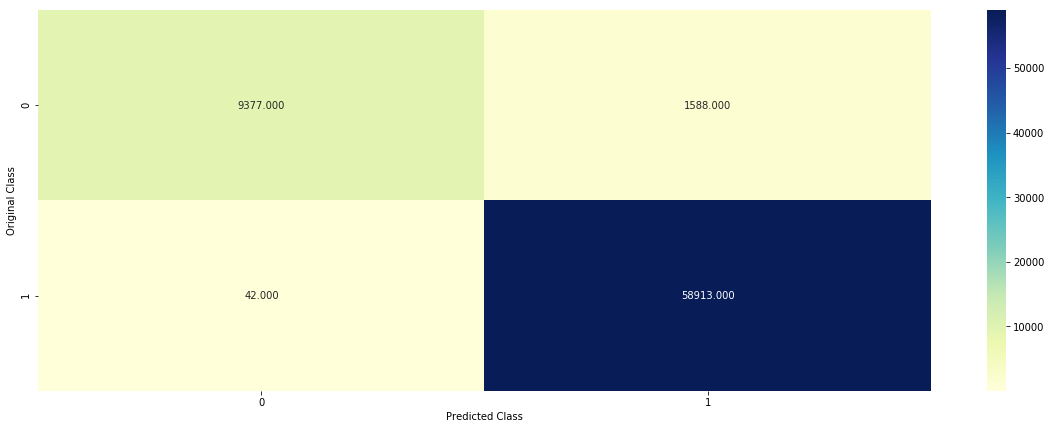

Test
-------------------- Confusion matrix --------------------


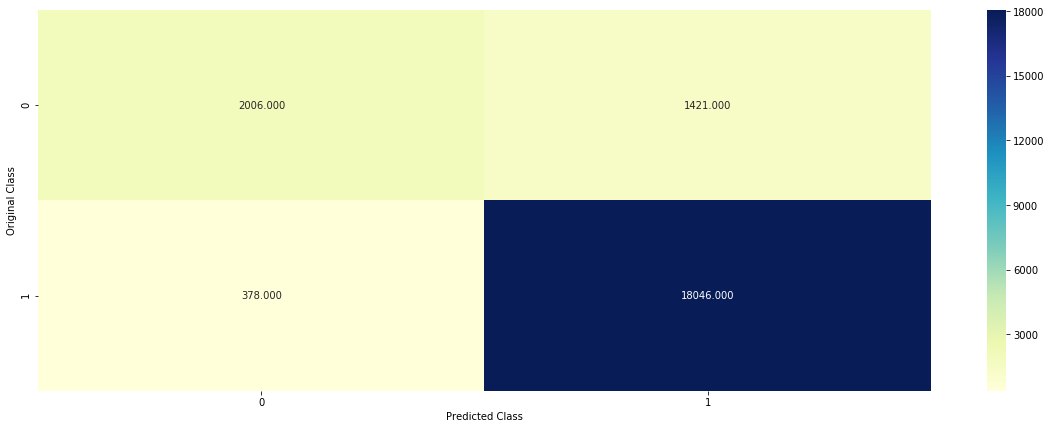

In [23]:
clf = SGDClassifier(class_weight='balanced', alpha=alph, penalty='l1', loss='log', random_state=42)
print("Train")
predict_and_plot_confusion_matrix(train, y_train,train, y_train, clf)
print("Test")
predict_and_plot_confusion_matrix(train, y_train,test, y_test, clf)


In [24]:
x = clf.coef_

####  Sparsity

In [25]:
findSparsity(clf)

1133802

####  Pertubation

In [26]:
train_1 = doPertubation(train)

In [27]:
clf = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l1',loss='log', random_state=42)
clf.fit(train_1, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
y = clf.coef_

In [29]:
a = findPercentageDifference(x,y)

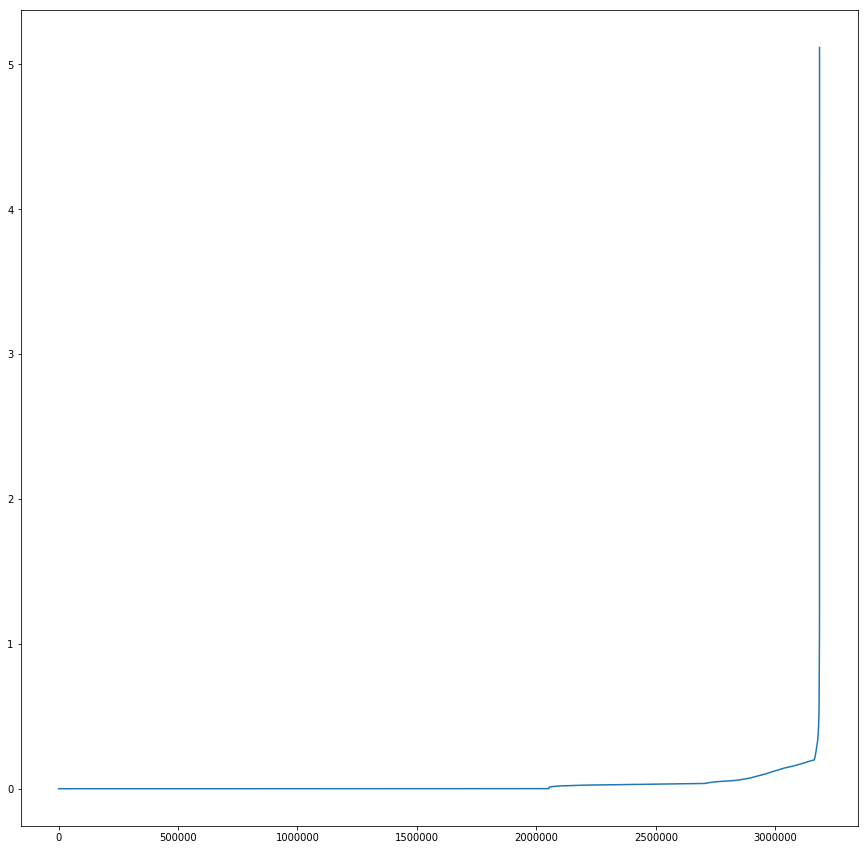

In [30]:
b = np.sort(a.ravel())
plot(b)

#####  Features whose % change is above threshold

In [31]:
percentage_change_flattened = a.ravel()
c = b>0.01
indices = np.where(c)
words = getImportantFeatures(indices[0],feature_names)
print(len(words))
print(words[:20])

1131227
['perfect thank ami', 'perfect thank ever', 'perfect thank gift', 'perfect thank god', 'perfect thank thank', 'perfect thanksgiv', 'perfect thanksgiv here', 'perfect there', 'perfect there doubt', 'perfect there much', 'perfect therefor', 'perfect therefor quench', 'perfect theyr', 'perfect theyr carbon', 'perfect theyr crunchi', 'perfect theyr cute', 'perfect theyr hard', 'perfect theyr sturdi', 'perfect thick', 'perfect thick bite']


####  Important Features

In [32]:
indices = np.argsort(-clf.coef_)[0][:]
positive_indices = indices[:20]
words = getImportantFeatures(positive_indices,feature_names)
print(words)

['delici', 'favorit', 'keep', 'high recommend', 'perfect', 'easi', 'happi', 'excel', 'glad', 'best', 'help', 'nice', 'run', 'alway', 'great', 'wonder', 'sometim', 'shake', 'amaz', 'muffin']


In [33]:
negative_indices = indices[-20:]
words = getImportantFeatures(negative_indices,feature_names)
print(words)

['gross', 'safeti seal cap', 'differ food', 'olli', 'under kidney diseas', 'under kidney', 'safeti', 'salsa garden', 'pgpr', 'caus', 'lime juic', 'key lime', 'refus', 'multipl', 'diseas', 'kidney diseas', 'under', 'lime', 'key', 'kidney']


In [33]:
print(clf.coef_.shape)

(1, 3185692)


# TFIDF

In [29]:
train = loadPickleData("tfidf_train.pickle")
test = loadPickleData('tfidf_test.pickle')
cv = loadPickleData('tfidf_cv.pickle')

In [30]:
train.shape

(69920, 42422)

In [31]:
tf_idf_vect = loadPickleData('tf_idf_vect.pickle')
feature_names = tf_idf_vect.get_feature_names()

for alpha = 1e-14
Fpr : 0.39985406785844585
Sparsity : 45560
for alpha = 1e-13
Fpr : 0.39365195184239327
Sparsity : 45574
for alpha = 1e-12
Fpr : 0.40277271068952936
Sparsity : 45560
for alpha = 1e-11
Fpr : 0.39328712148850786
Sparsity : 45573
for alpha = 1e-10
Fpr : 0.3940167821962787
Sparsity : 45638
for alpha = 1e-09
Fpr : 0.3918278000729661
Sparsity : 45635
for alpha = 1e-08
Fpr : 0.3954761036118205
Sparsity : 45462
for alpha = 1e-07
Fpr : 0.3878146661802262
Sparsity : 44163
for alpha = 1e-06
Fpr : 0.3852608537030281
Sparsity : 34133
for alpha = 1e-05
Fpr : 0.35716891645384896
Sparsity : 6091
for alpha = 0.0001
Fpr : 0.4345129514775629
Sparsity : 389
for alpha = 0.001
Fpr : 0.8055454213790587
Sparsity : 27
for alpha = 0.01
Fpr : 1.0
Sparsity : 0
for alpha = 0.1
Fpr : 1.0
Sparsity : 0
for alpha = 1
Fpr : 1.0
Sparsity : 0
for alpha = 10
Fpr : 1.0
Sparsity : 0
for alpha = 100
Fpr : 1.0
Sparsity : 0
for alpha = 1e-14
Fpr : 0.1622435020519836
Sparsity : 45560
for alpha = 1e-13
Fpr : 0.1

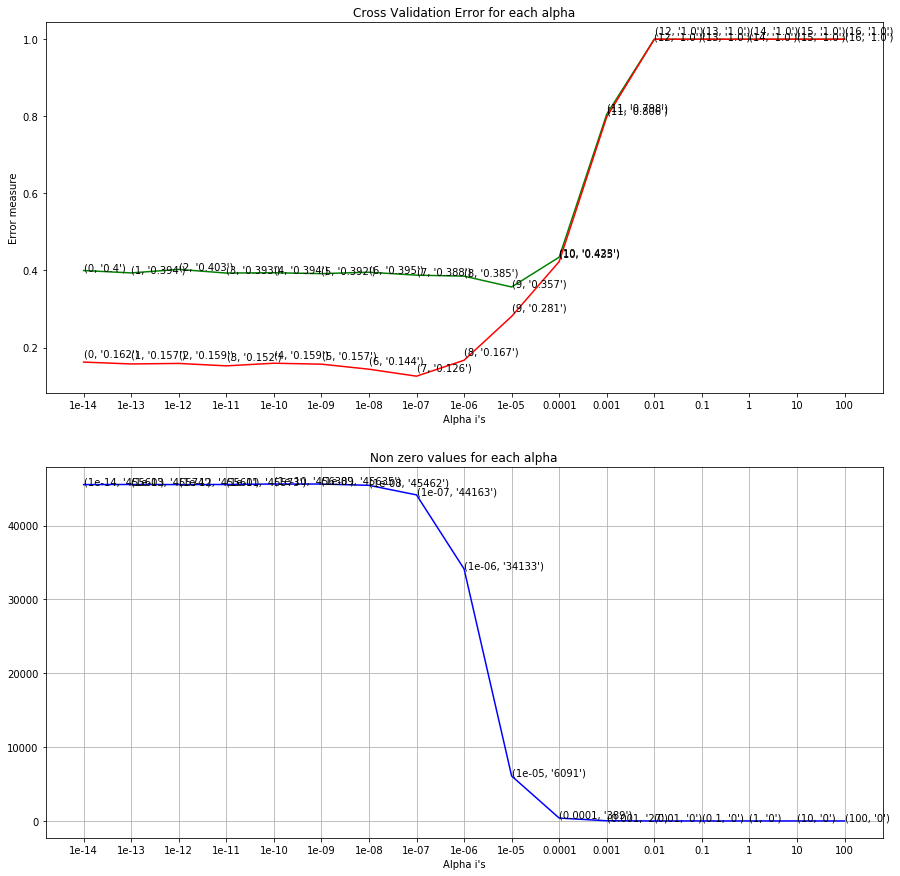

-------------------- Confusion matrix --------------------


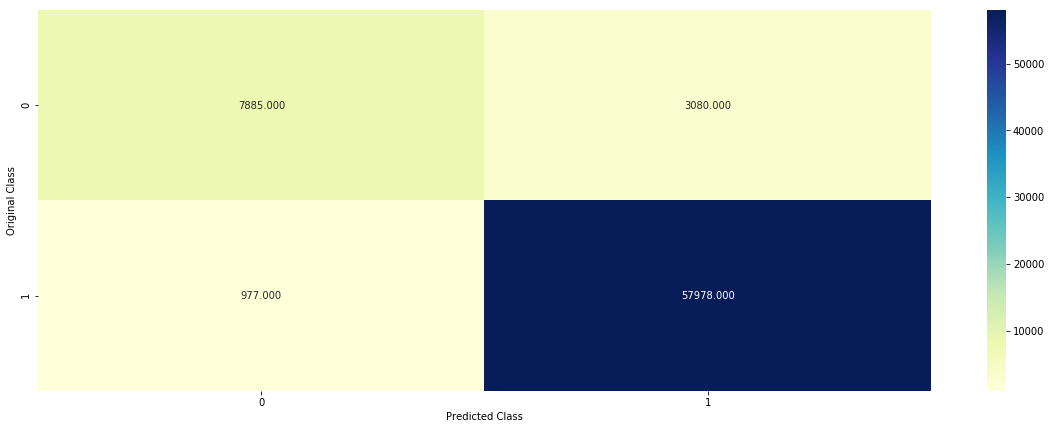

For values of best alpha =  1e-05 The train fpr is: 0.2808937528499772
For values of best alpha =  1e-05 The cross validation fpr is: 0.35716891645384896
-------------------- Confusion matrix --------------------


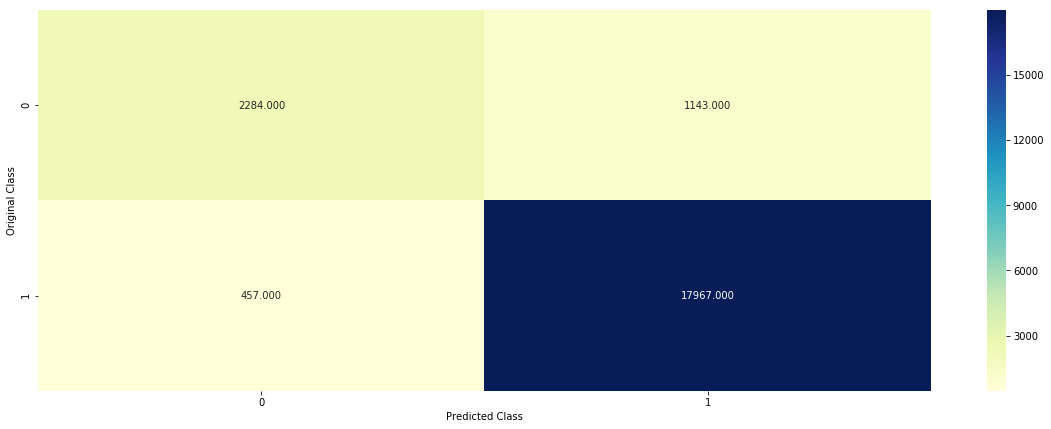

For values of best alpha =  1e-05 The test fpr is: 0.3335278669390137


In [46]:
clf,alph = performHyperParameterTuningC(train,cv,test)

In [31]:
clf = SGDClassifier(class_weight='balanced', alpha=alph, penalty='l2', loss='log', random_state=42)
clf.fit(train, y_train)

/home/admin1/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

####  Important Features

In [33]:
indices = np.argsort(-clf.coef_)[0][:]
positive_indices = indices[:20]
words = getImportantFeatures(positive_indices,feature_names)
print(words)

['delici', 'perfect', 'high recommend', 'great', 'wont disappoint', 'best', 'awesom', 'excel', 'love', 'fantast', 'yummi', 'nice', 'well worth', 'smooth', 'satisfi', 'worri', 'hook', 'amaz', 'terrif', 'wonder']


In [34]:
negative_indices = indices[-20:]
words = getImportantFeatures(negative_indices,feature_names)
print(words)

['tasteless', 'ruin', 'red dye', 'crappi', 'sad', 'box broken', 'ined', 'trash', 'devil', 'bland', 'unfortun', 'wont buy', 'return', 'disgust', 'chickpea', 'terribl', 'horribl', 'aw', 'disappoint', 'worst']


# AvgW2V

In [39]:
train = loadPickleData("avg_w2v_train.pickle")
test = loadPickleData('avg_w2v_test.pickle')
cv = loadPickleData('avg_w2v_cv.pickle')

for alpha = 1e-14
Fpr : 1.0
Sparsity : 50
for alpha = 1e-13
Fpr : 1.0
Sparsity : 50
for alpha = 1e-12
Fpr : 1.0
Sparsity : 50
for alpha = 1e-11
Fpr : 1.0
Sparsity : 50
for alpha = 1e-10
Fpr : 1.0
Sparsity : 50
for alpha = 1e-09
Fpr : 1.0
Sparsity : 50
for alpha = 1e-08
Fpr : 1.0
Sparsity : 50
for alpha = 1e-07
Fpr : 1.0
Sparsity : 50
for alpha = 1e-06
Fpr : 1.0
Sparsity : 40
for alpha = 1e-05
Fpr : 1.0
Sparsity : 4
for alpha = 0.0001
Fpr : 1.0
Sparsity : 6
for alpha = 0.001
Fpr : 1.0
Sparsity : 1
for alpha = 0.01
Fpr : 1.0
Sparsity : 0
for alpha = 0.1
Fpr : 1.0
Sparsity : 0
for alpha = 1
Fpr : 1.0
Sparsity : 0
for alpha = 10
Fpr : 1.0
Sparsity : 0
for alpha = 100
Fpr : 1.0
Sparsity : 0
for alpha = 1e-14
Fpr : 1.0
Sparsity : 50
for alpha = 1e-13
Fpr : 1.0
Sparsity : 50
for alpha = 1e-12
Fpr : 1.0
Sparsity : 50
for alpha = 1e-11
Fpr : 1.0
Sparsity : 50
for alpha = 1e-10
Fpr : 1.0
Sparsity : 50
for alpha = 1e-09
Fpr : 1.0
Sparsity : 50
for alpha = 1e-08
Fpr : 1.0
Sparsity : 50
for alpha =

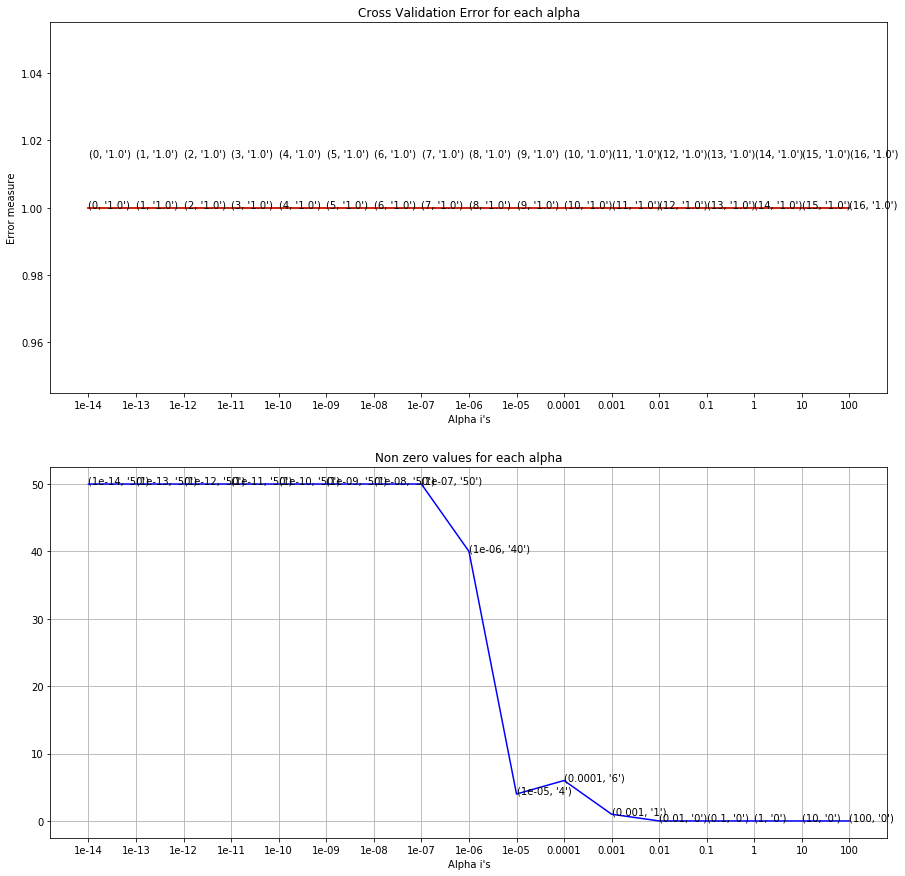

-------------------- Confusion matrix --------------------


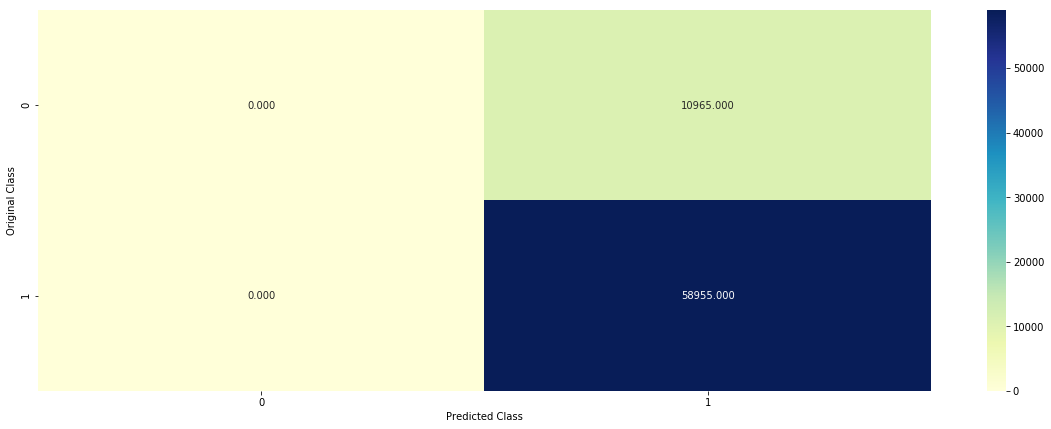

For values of best alpha =  1e-14 The train fpr is: 1.0
For values of best alpha =  1e-14 The cross validation fpr is: 1.0
-------------------- Confusion matrix --------------------


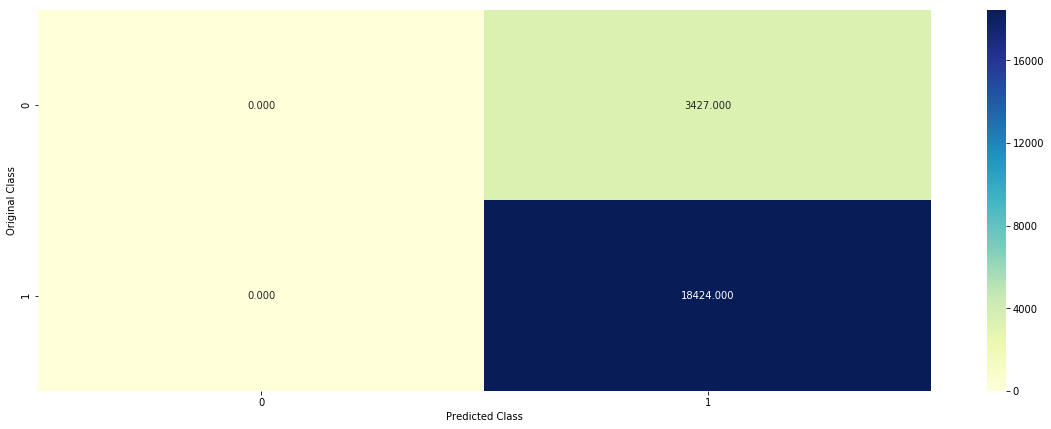

For values of best alpha =  1e-14 The test fpr is: 1.0


In [40]:
clf,alph = performHyperParameterTuningC(train,cv,test)


# TFIDF-W2V

In [41]:
train = loadPickleData("tfidf_w2v_train.pickle")
test = loadPickleData('tfidf_w2v_test.pickle')
cv = loadPickleData('tfidf_w2v_cv.pickle')

for alpha = 1e-14
Fpr : 1.0
Sparsity : 50
for alpha = 1e-13
Fpr : 1.0
Sparsity : 50
for alpha = 1e-12
Fpr : 1.0
Sparsity : 50
for alpha = 1e-11
Fpr : 1.0
Sparsity : 50
for alpha = 1e-10
Fpr : 1.0
Sparsity : 50
for alpha = 1e-09
Fpr : 1.0
Sparsity : 50
for alpha = 1e-08
Fpr : 1.0
Sparsity : 50
for alpha = 1e-07
Fpr : 1.0
Sparsity : 50
for alpha = 1e-06
Fpr : 1.0
Sparsity : 39
for alpha = 1e-05
Fpr : 1.0
Sparsity : 7
for alpha = 0.0001
Fpr : 1.0
Sparsity : 6
for alpha = 0.001
Fpr : 1.0
Sparsity : 1
for alpha = 0.01
Fpr : 1.0
Sparsity : 0
for alpha = 0.1
Fpr : 1.0
Sparsity : 0
for alpha = 1
Fpr : 1.0
Sparsity : 0
for alpha = 10
Fpr : 1.0
Sparsity : 0
for alpha = 100
Fpr : 1.0
Sparsity : 0
for alpha = 1e-14
Fpr : 1.0
Sparsity : 50
for alpha = 1e-13
Fpr : 1.0
Sparsity : 50
for alpha = 1e-12
Fpr : 1.0
Sparsity : 50
for alpha = 1e-11
Fpr : 1.0
Sparsity : 50
for alpha = 1e-10
Fpr : 1.0
Sparsity : 50
for alpha = 1e-09
Fpr : 1.0
Sparsity : 50
for alpha = 1e-08
Fpr : 1.0
Sparsity : 50
for alpha =

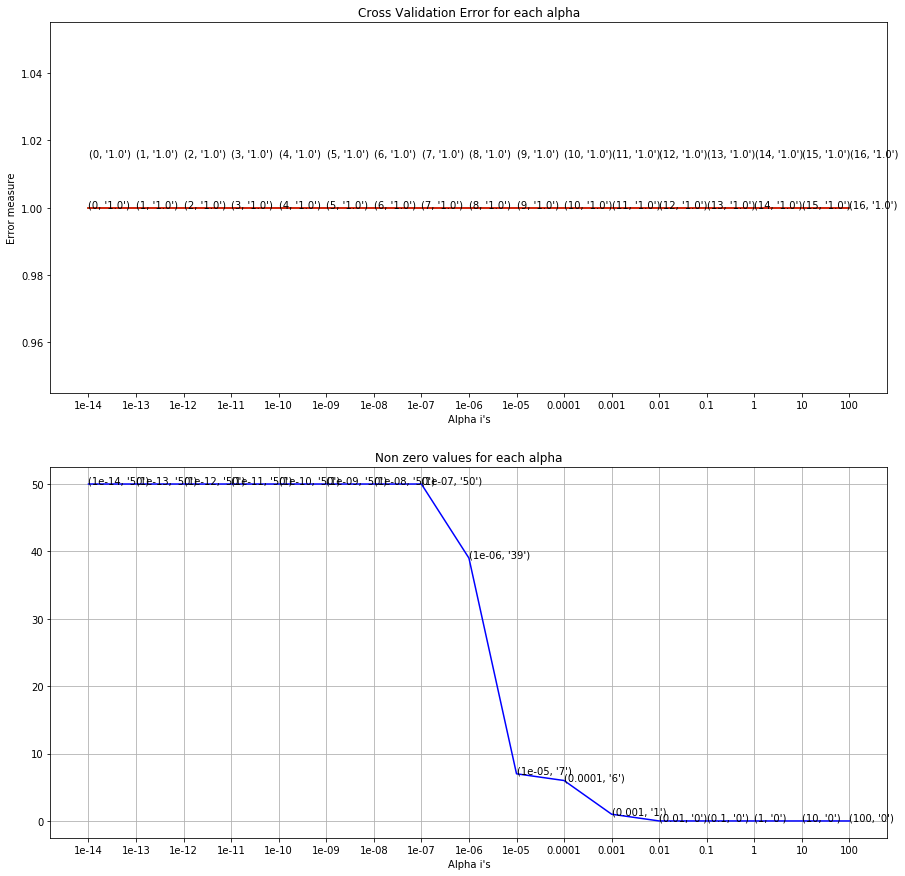

-------------------- Confusion matrix --------------------


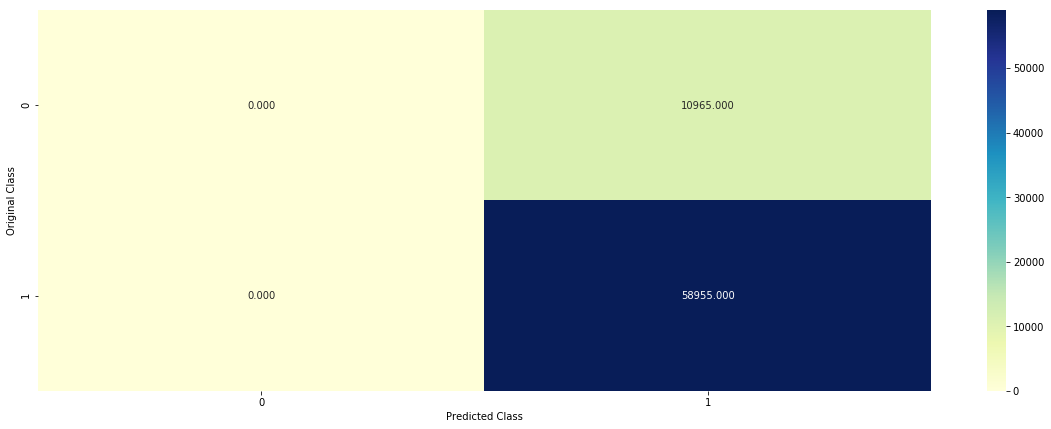

For values of best alpha =  1e-14 The train fpr is: 1.0
For values of best alpha =  1e-14 The cross validation fpr is: 1.0
-------------------- Confusion matrix --------------------


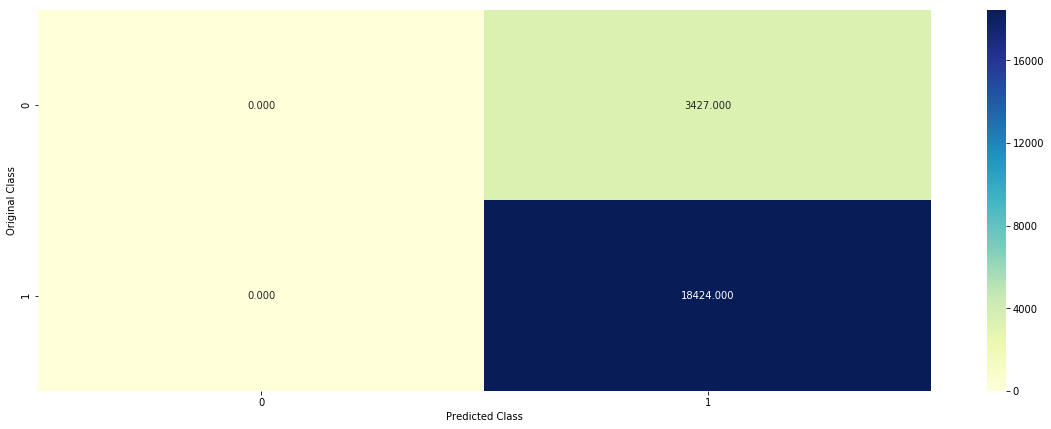

For values of best alpha =  1e-14 The test fpr is: 1.0


In [26]:
clf,alph = performHyperParameterTuningC(train,cv,test)

### Summary

| Vectorizer | Alpha   | Fpr - train | Fpr -test |
|------------|---------|-------------|-----------|
| BOW        | 0.001   | 0.14        | 0.41      |
| TFIDF      | 0.00001 | 0.33        | 0.28      |
| AvgW2V     | 0.0001  | 1           | 1         |
| TFIDFW2V   | 0.001   | 1           | 1         |